In [110]:
import numpy as np
import matplotlib.pyplot as plt
from nbodykit.lab import *
from nbodykit import style, setup_logging
import matplotlib.pyplot as plt
plt.style.use(style.notebook)
import gc
import pandas as pd
import nbodykit as nb

In [111]:
data_read = pd.read_csv('./Ne_Galaxy_Mstar10_ver2.csv')
print(data_read)

                X           Y          Z           Mass  StellarMass  \
0       43.718810   48.813640  147.59496  189451.730000   783.803400   
1       45.442272   51.850200  146.41650   53636.387000   374.465360   
2       44.490760   49.091713  147.87057    1323.301300    84.685110   
3       43.820786   50.939400  147.71104     730.714970    35.296432   
4       44.302578   49.630974  147.86949     690.085700    32.565090   
...           ...         ...        ...            ...          ...   
97008   10.228784  118.992710  192.99580       7.450773     1.552666   
97009  176.708270  108.186970  186.70604       8.753557     1.273605   
97010   44.697636   47.188305  149.88548       9.418049     1.096117   
97011   43.667706   73.888084  147.98112       5.398947     1.028258   
97012   45.803550   69.286766  145.47922       6.340109     1.122643   

               Vx          Vy          Vz          Nex          Ney  \
0       472.19620   450.85000  -260.74692  4156.156662  4155.531

In [112]:
sub_data = data_read[['HaloMass','Nex']]
print(sub_data)
sub_np = np.array(sub_data)
print(sub_np)

            HaloMass          Nex
0      286449.700000  4156.156662
1      286449.700000  1115.259432
2      286449.700000  3963.902220
3      286449.700000    12.345561
4      286449.700000  3526.170518
...              ...          ...
97008       8.873478   103.257322
97009      10.944721    80.724896
97010      10.722833    12.335553
97011       6.748273    40.062974
97012       6.541734    13.234448

[97013 rows x 2 columns]
[[2.86449700e+05 4.15615666e+03]
 [2.86449700e+05 1.11525943e+03]
 [2.86449700e+05 3.96390222e+03]
 ...
 [1.07228330e+01 1.23355526e+01]
 [6.74827340e+00 4.00629735e+01]
 [6.54173400e+00 1.32344476e+01]]


In [113]:
mass = sub_np[:,0]
tau = sub_np[:,1]
idx = np.argsort(mass)  
mass_sorted = mass[idx]  
tau_sorted  = tau[idx] 

In [114]:
exp_edges = np.arange(0.5, 5 + 0.5, 0.5)   
edges     = 10 ** exp_edges 

In [115]:
bin_idx = np.digitize(mass, edges) - 1 

In [116]:
df = pd.DataFrame({'mass': mass, 'tau': tau, 'bin': bin_idx})
df = df[df['bin'].between(0, len(edges)-2)]

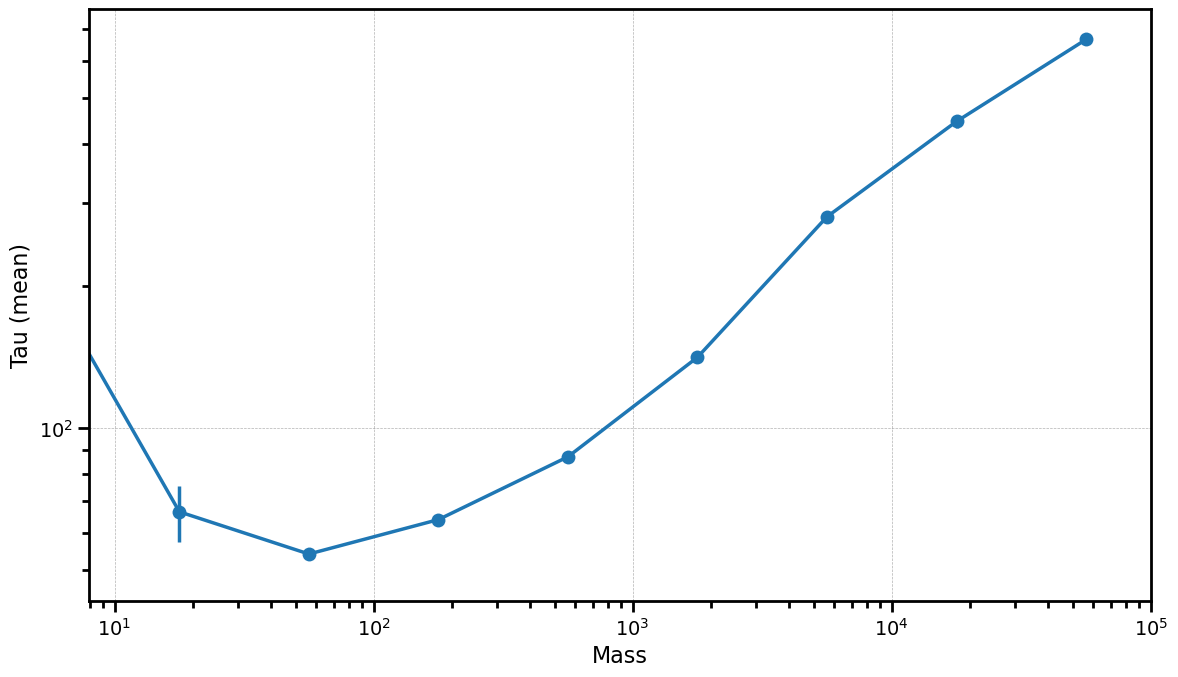

In [117]:

from sklearn.utils import resample

def bootstrap_ci(data, func=np.mean, alpha=0.16, B=5000, seed=42):
    boots = [
        func(resample(data, replace=True, random_state=seed+i))
        for i in range(B)
    ]
    lo, hi = np.percentile(boots, [100*alpha, 100*(1-alpha)])
    est = func(data)
    return est, est-lo, hi-est


bin_centers = np.sqrt(edges[:-1] * edges[1:])   
y_est, err_low, err_high, x_plot = [], [], [], []

for b, grp in df.groupby('bin'):
    tau_sample = grp['tau'].values
    if len(tau_sample) < 3:      
        continue
    est, el, eh = bootstrap_ci(tau_sample,
                               func=np.mean,  
                               alpha=0.16,
                               B=3000,
                               seed=42)
    x_plot.append(bin_centers[b])
    y_est.append(est)
    err_low.append(el)
    err_high.append(eh)


plt.errorbar(x_plot, y_est, yerr=[err_low, err_high],
             fmt='o-', capsize=3)
plt.xscale('log')
plt.xlabel('Mass')
plt.ylabel('Tau (mean)')
plt.yscale('log')
plt.xlim(10**0.9,10**5)
plt.tight_layout()
plt.show()


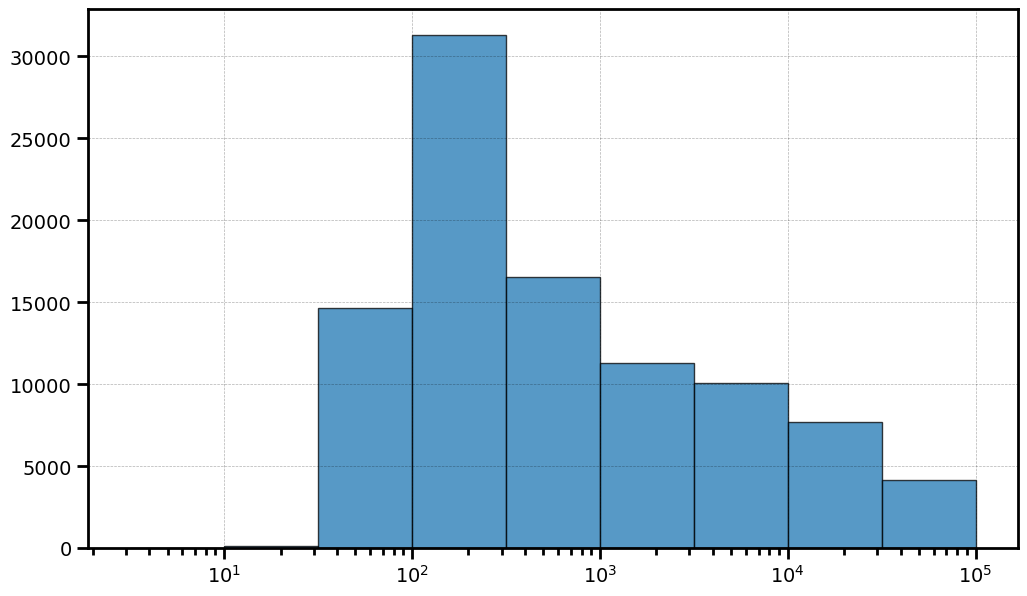

In [118]:
plt.hist(df['mass'], bins=edges, edgecolor='k', alpha=0.75)
plt.xscale('log')

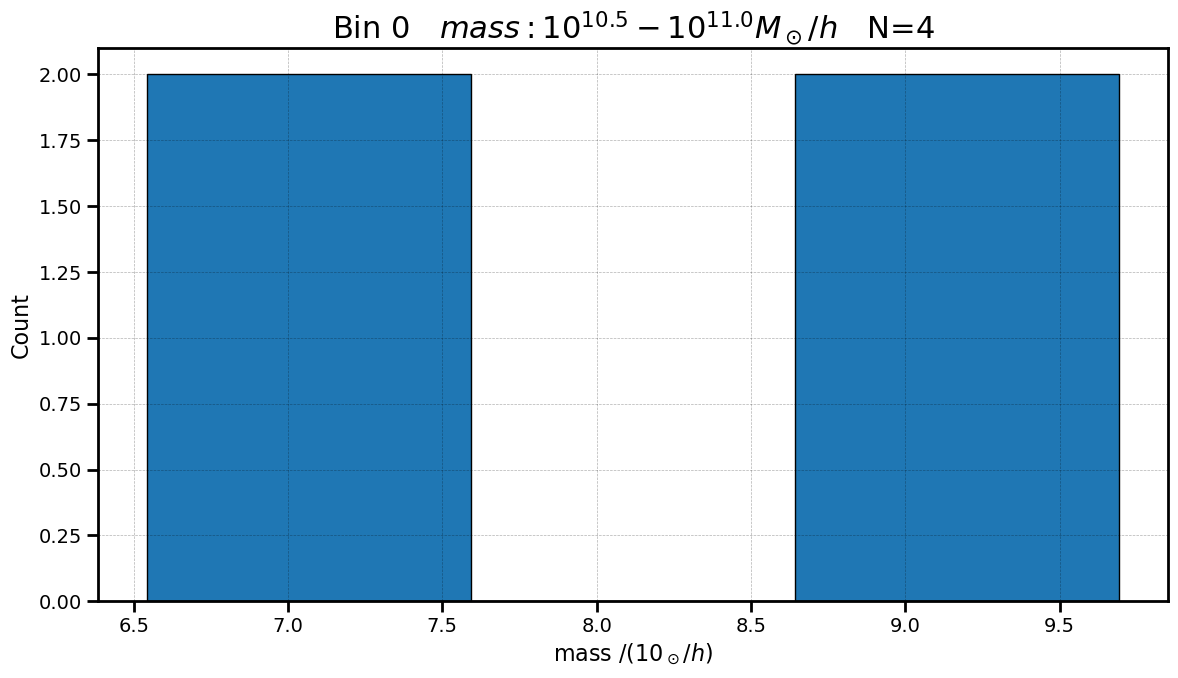

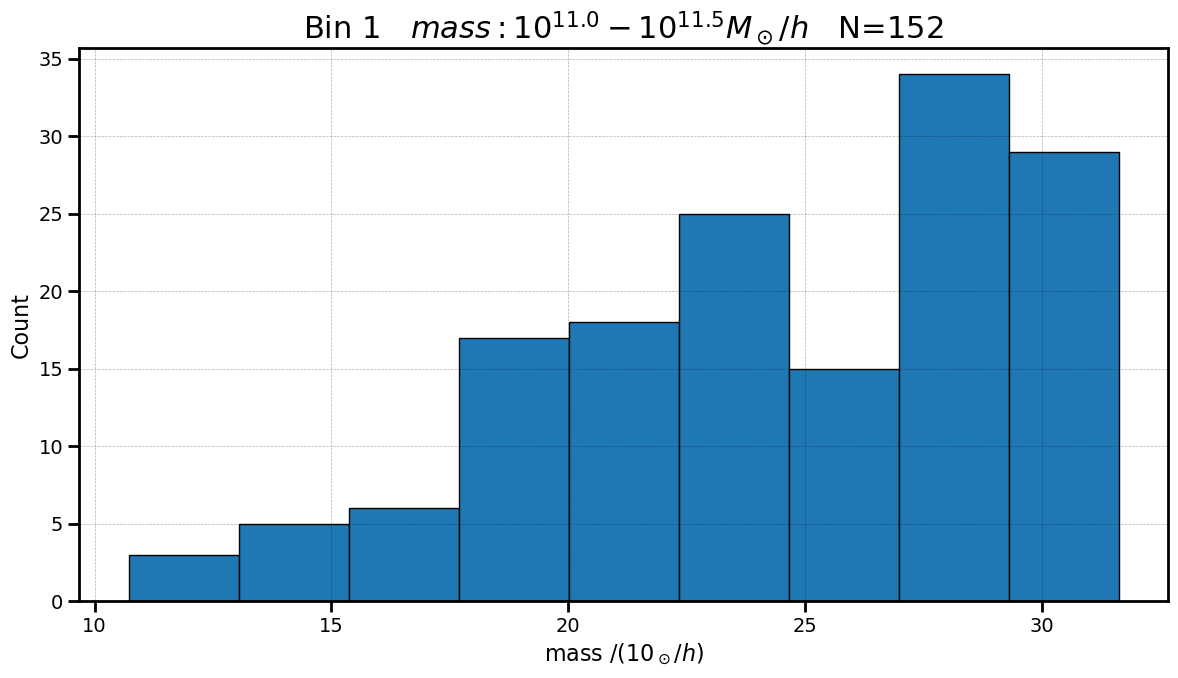

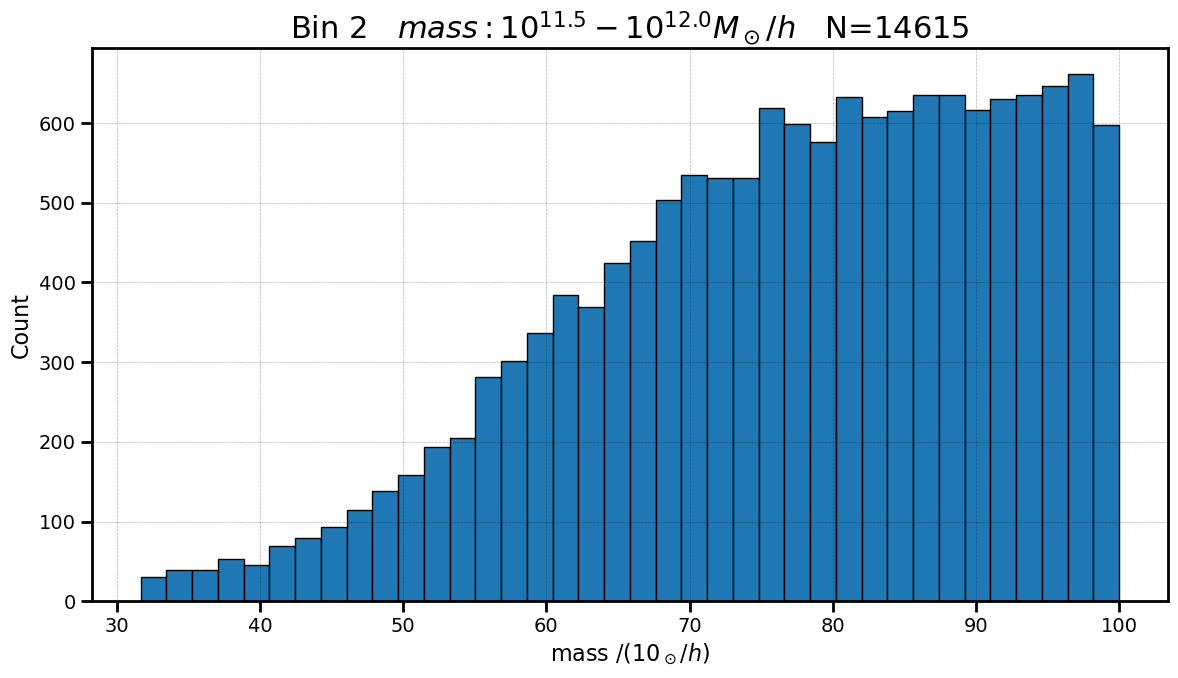

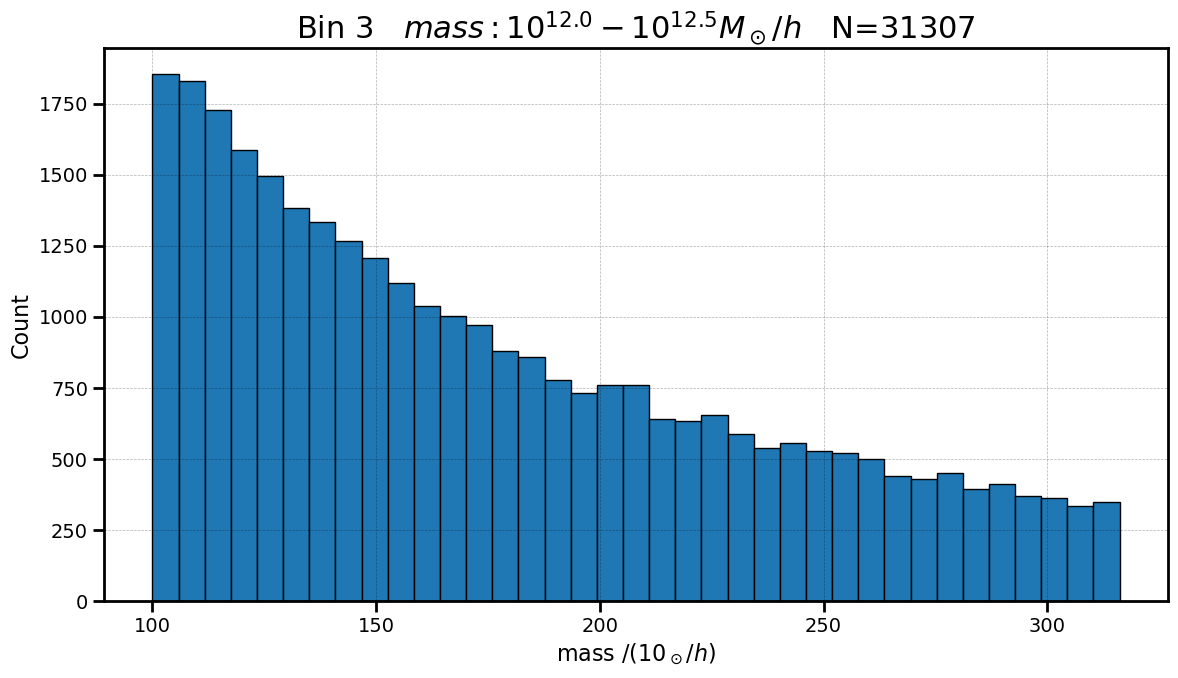

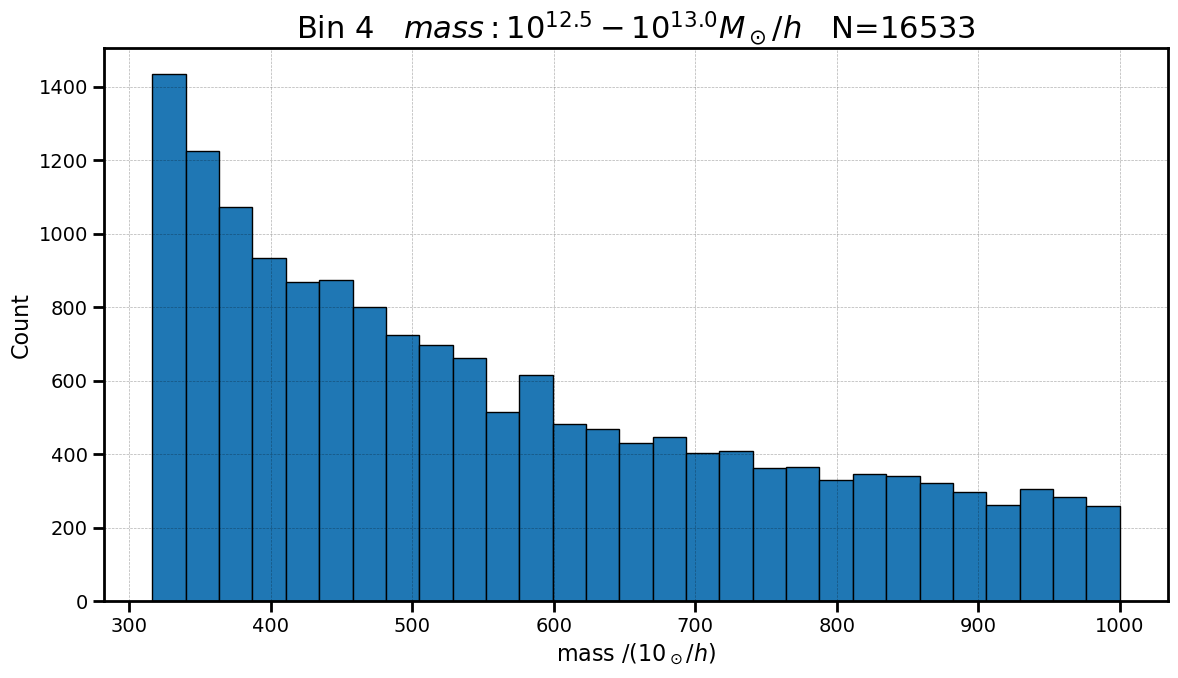

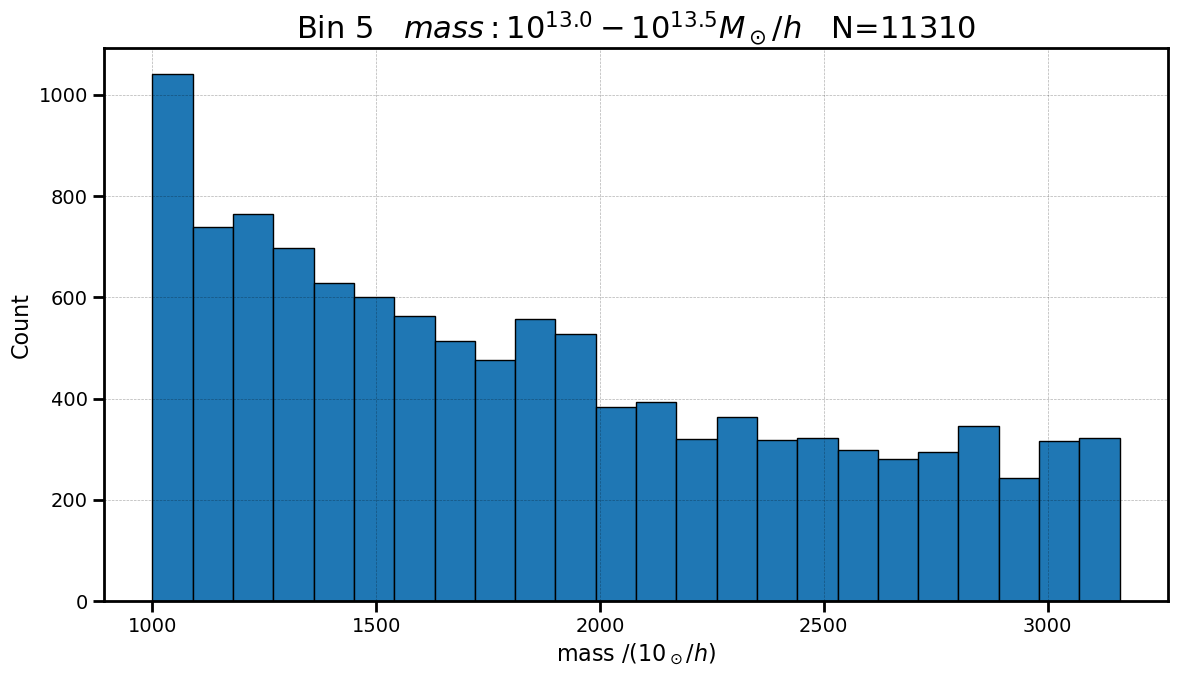

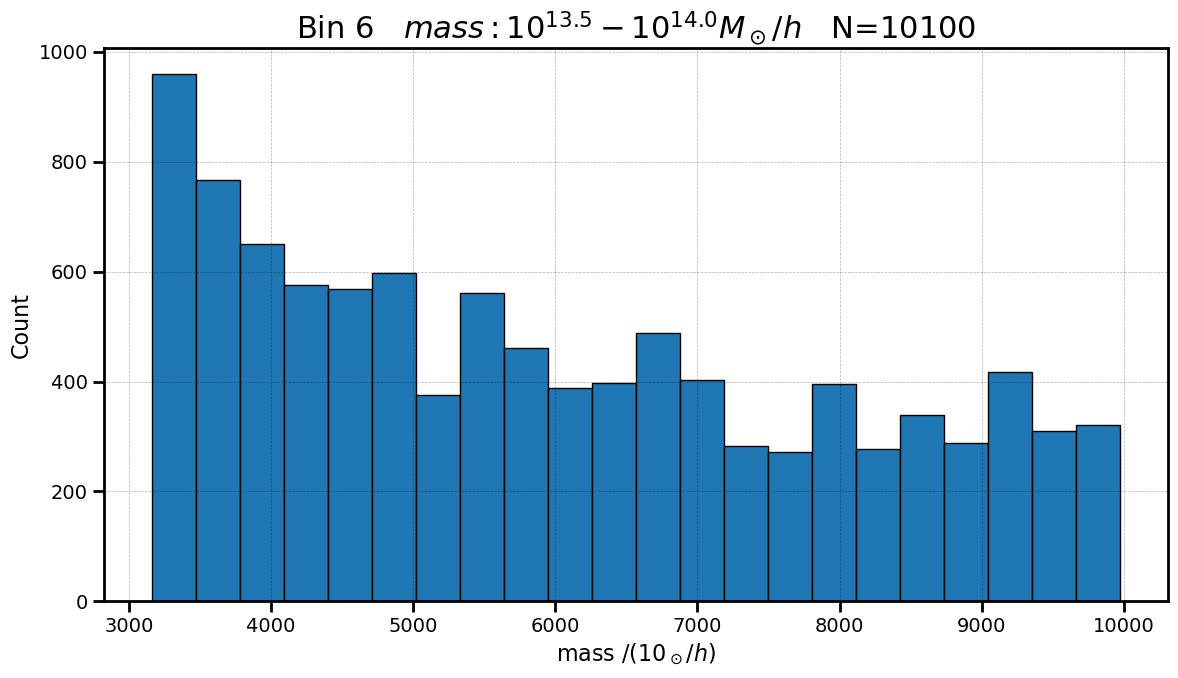

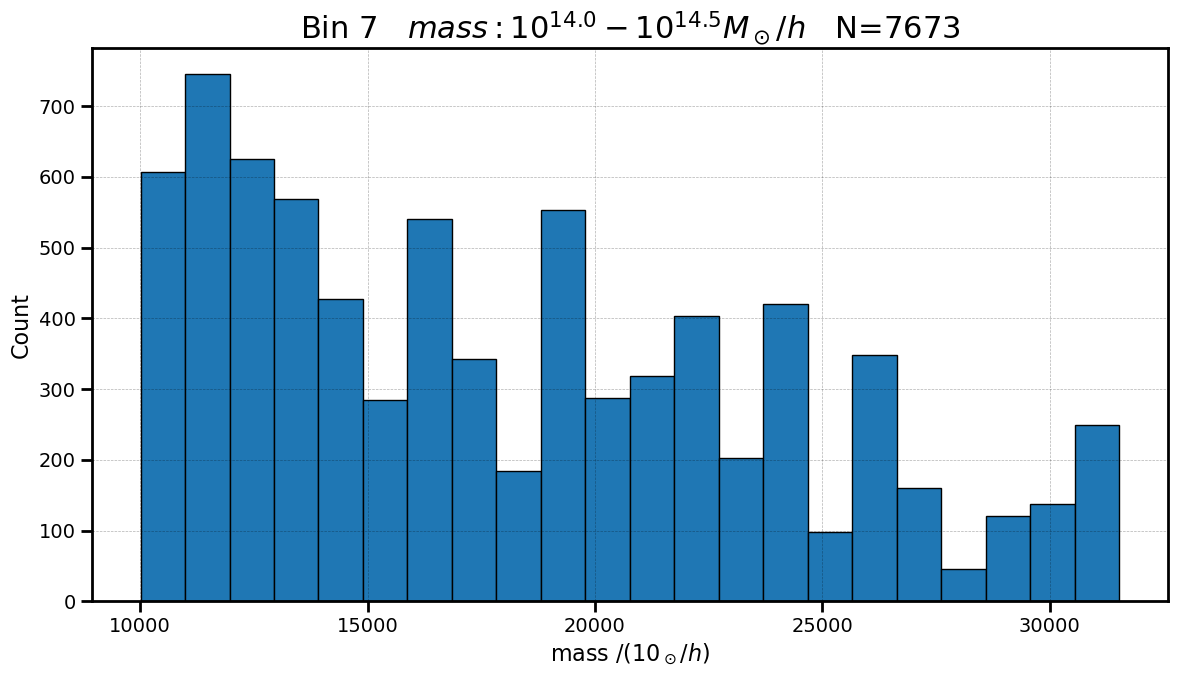

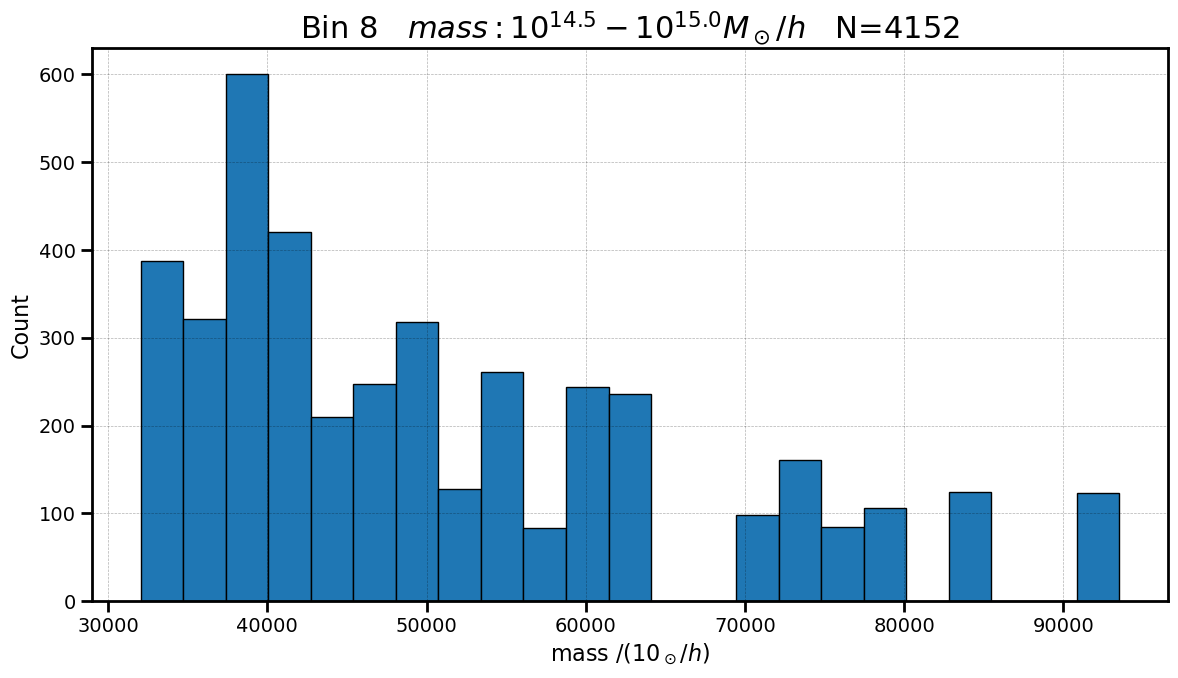

In [119]:


for b in sorted(df['bin'].unique()):
    mass_sample = df.loc[df['bin'] == b, 'mass'].values
    if len(mass_sample) == 0:
        continue
    
    left_val = edges[b]             
    exp_val  = np.log10(left_val)

    plt.figure()        
    plt.hist(mass_sample,
             bins='auto',             
             edgecolor='black')
    # plt.xscale('log')                
    plt.xlabel(f'mass $/(10_\odot/h)$')
    plt.ylabel('Count')
    plt.title(f'Bin {b}   $mass:10^{{{10+exp_val}}}-10^{{{10.5+exp_val}}}M_\odot/h$   N={len(mass_sample)}')
    plt.tight_layout()
    plt.show()


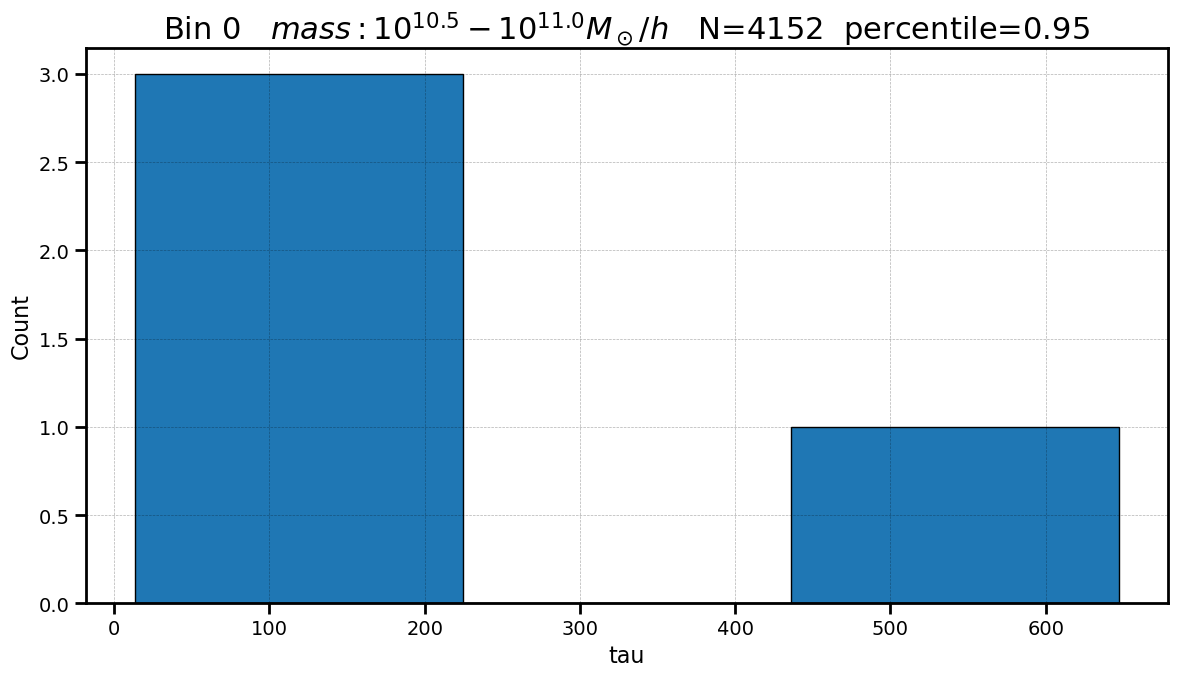

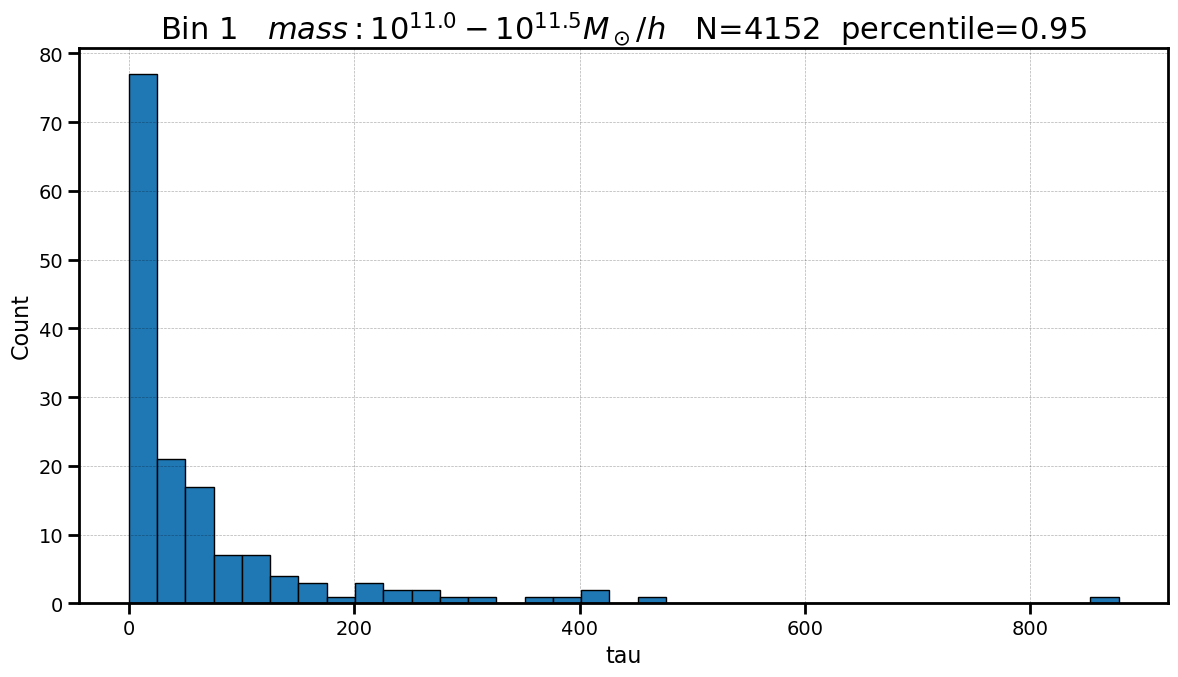

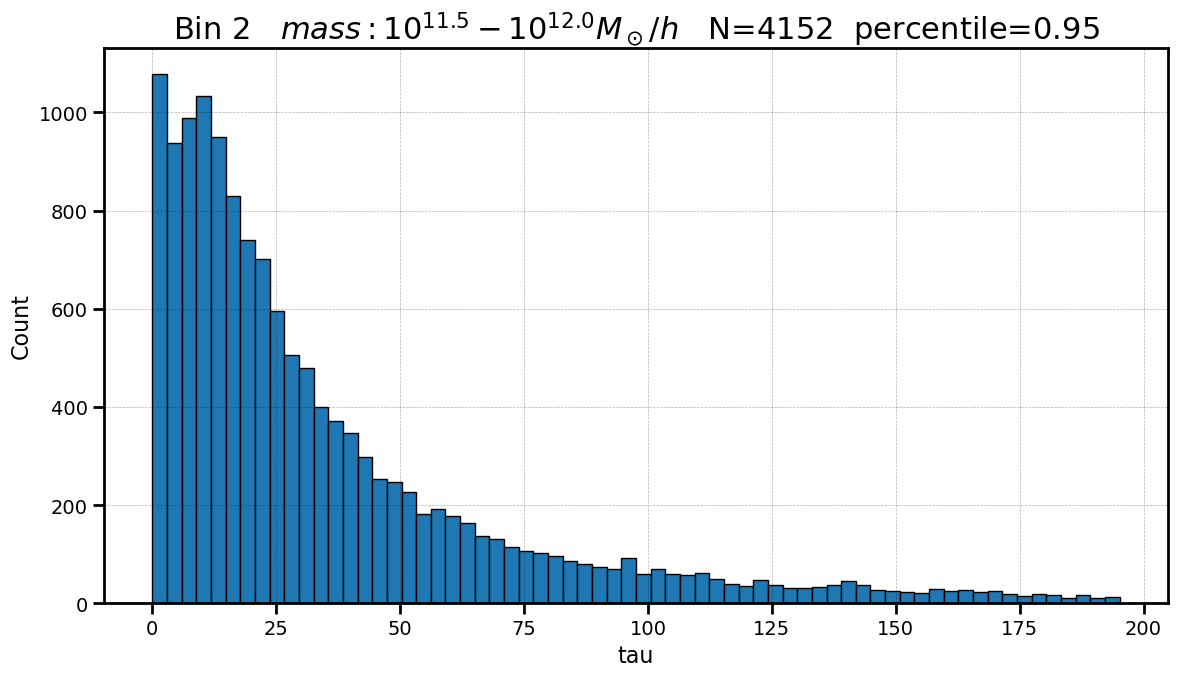

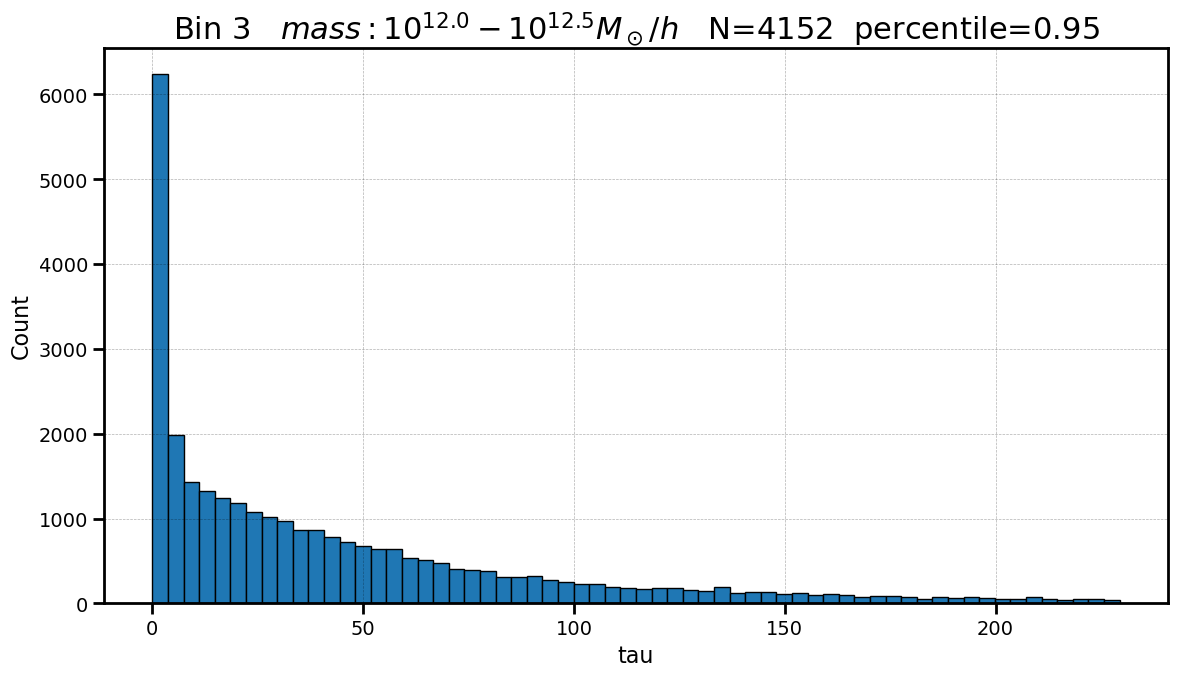

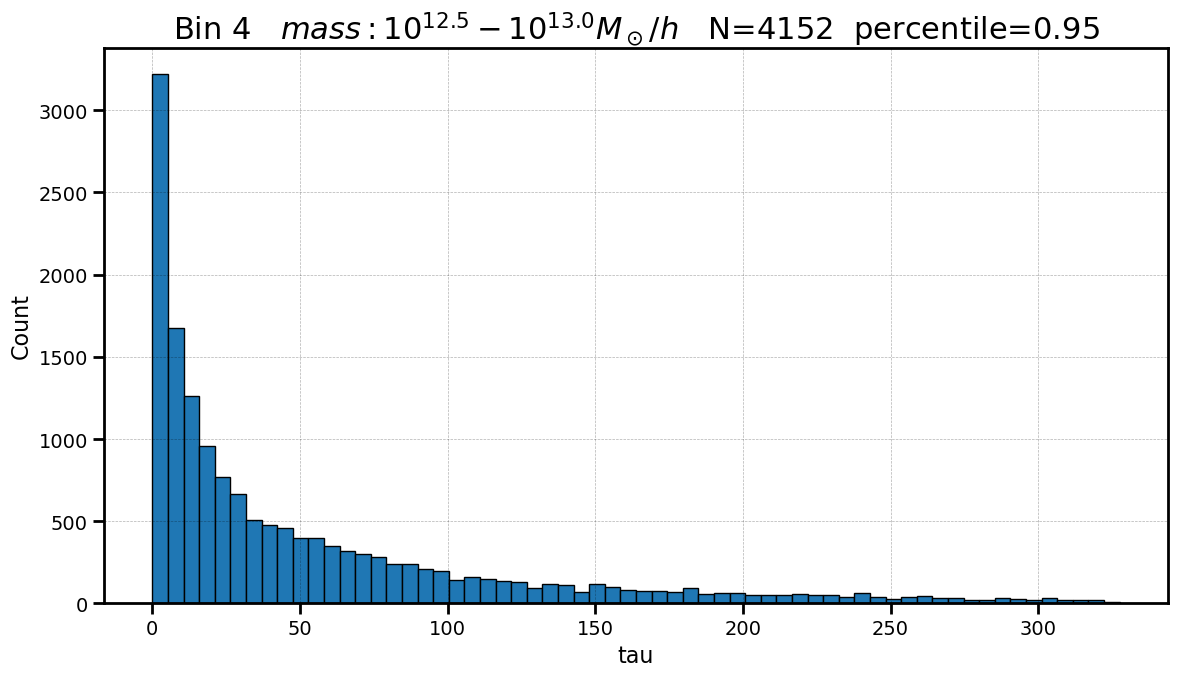

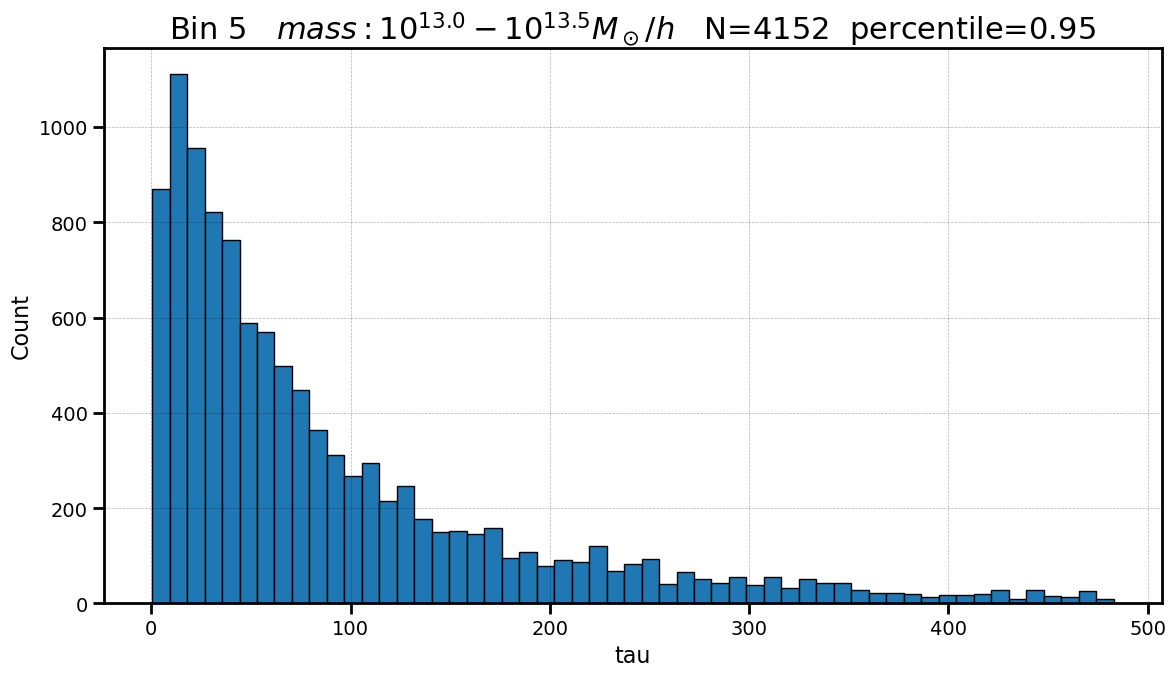

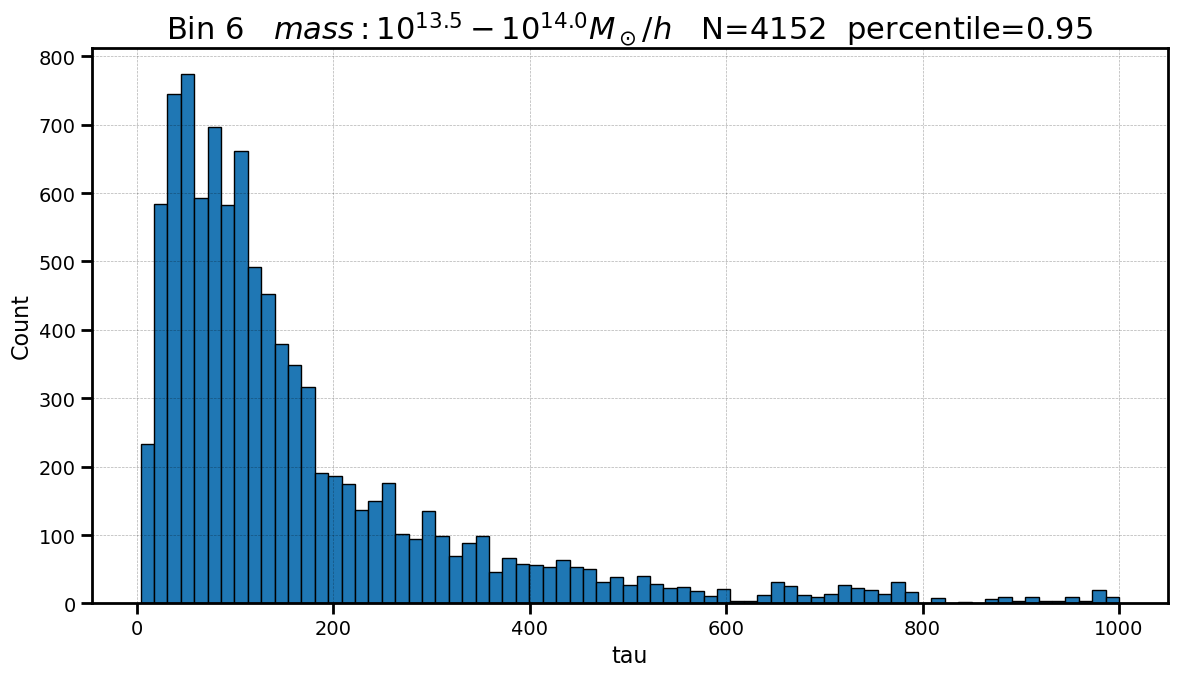

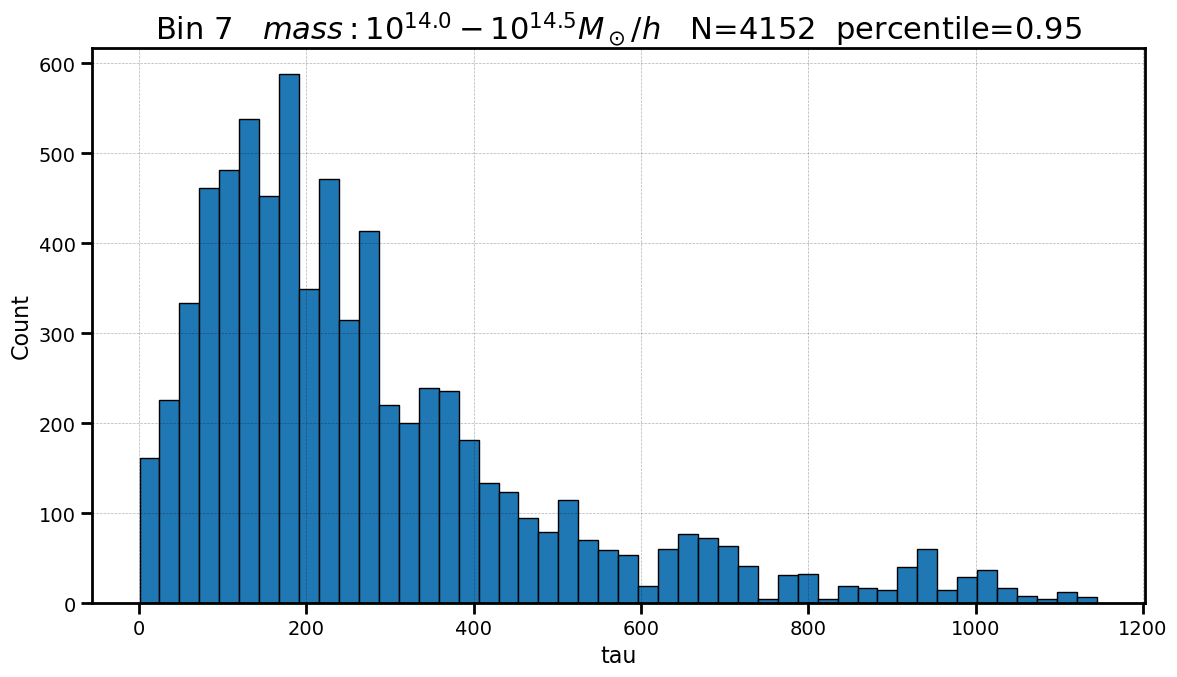

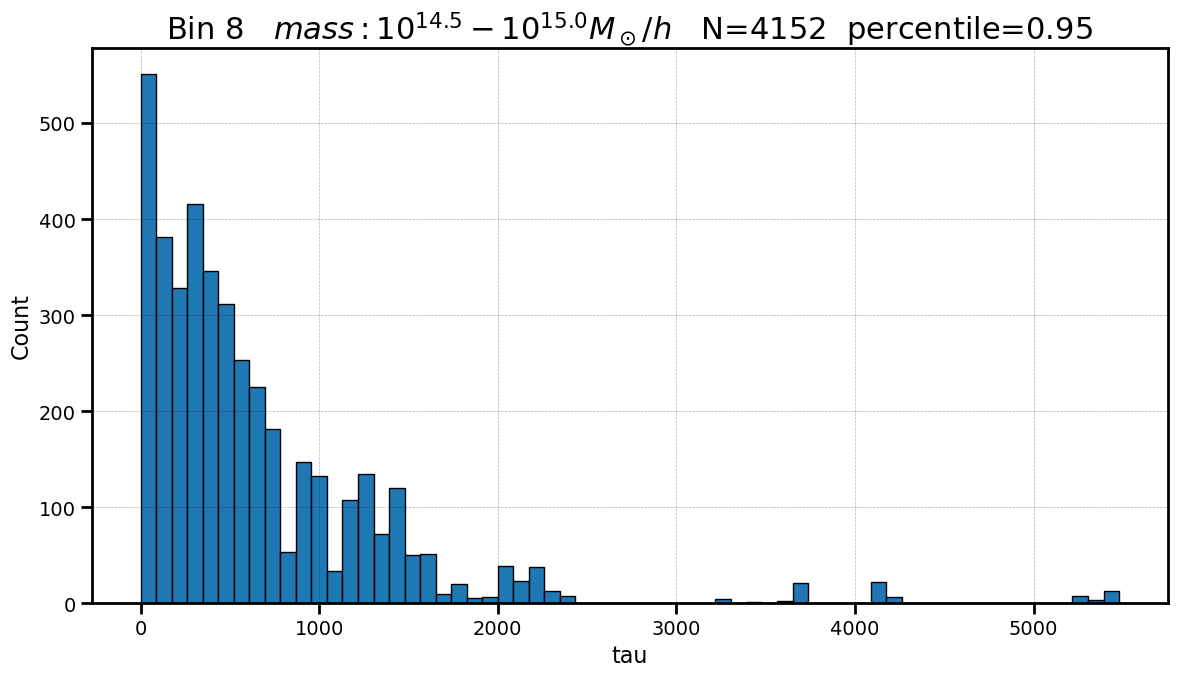

In [120]:
for b in sorted(df['bin'].unique()):
    tau_sample = df.loc[df['bin'] == b, 'tau'].values
    if len(tau_sample) == 0:
        continue
    
    if len(tau_sample) <= 5000:
        bins = 'auto'
    else:
        p95 = np.percentile(tau_sample, 95) 
        mask = tau_sample <= p95 
        tau_sample = tau_sample[mask]


    left_val = edges[b]             
    exp_val  = np.log10(left_val)
    plt.figure()        
    plt.hist(tau_sample,
             bins=bins,             
             edgecolor='black')
    # plt.xscale('log')                
    plt.xlabel('tau')
    plt.ylabel('Count')
    plt.title(fr'Bin {b}   $mass:10^{{{10+exp_val}}}-10^{{{10.5+exp_val}}}M_\odot/h$   N={len(mass_sample)}  percentile=0.95')
    plt.tight_layout()
    plt.show()

In [121]:
print(tau_sample)

[693.54878322 383.90003533 176.40826443 ... 355.62070534 353.22039043
 352.26434534]


In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample                    

def bootstrap_ci_sklearn(data, *, size, 
                          stat_func=np.mean, seed=42):
    #在每个bin内进行size次抽样
    rng_seed = np.random.default_rng(seed).integers(0, 2**32-1, size=size)
    data_resample_mean = []
    for s in rng_seed:
    #每一次抽样，计算抽样结果的平均值
        data_resample_s = resample(data, replace=True, random_state=s)
        data_resample_s_mean = stat_func(data_resample_s)
        data_resample_mean.append(data_resample_s_mean)
    #以这个平均值作为样本平均值，计算每个样本的标准差
    est = stat_func(data_resample_mean)
    # err = np.std(data_resample_mean)
    B = len(data_resample_mean)      
    sq_diff_sum = 0.0                 
    for theta_b in data_resample_mean:
        sq_diff_sum += (theta_b - est) ** 2
    err = (sq_diff_sum / (B - 1))
    # err = (sq_diff_sum / (B - 1)) ** 0.5
    # sum = 0
    # for dat in data:
    #     sum = sum + (est-dat)**2
    # err = np.sqrt(sum/(len(data)-1))
    return est, err

bin_ids   = np.sort(df['bin'].unique())
x_vals    = []
y_mean    = []
err       = []

for b in bin_ids:
    tau_b = df.loc[df['bin'] == b, 'tau'].values
    if tau_b.size < 5:
        continue
    est, err_b = bootstrap_ci_sklearn(tau_b,
                                       size=5000,
                                    #    stat_func=np.median,
                                       stat_func=np.mean,
                                       seed=42)

    x_vals.append(np.sqrt(edges[b]*edges[b+1]))     
    y_mean.append(est)
    err.append(err_b)




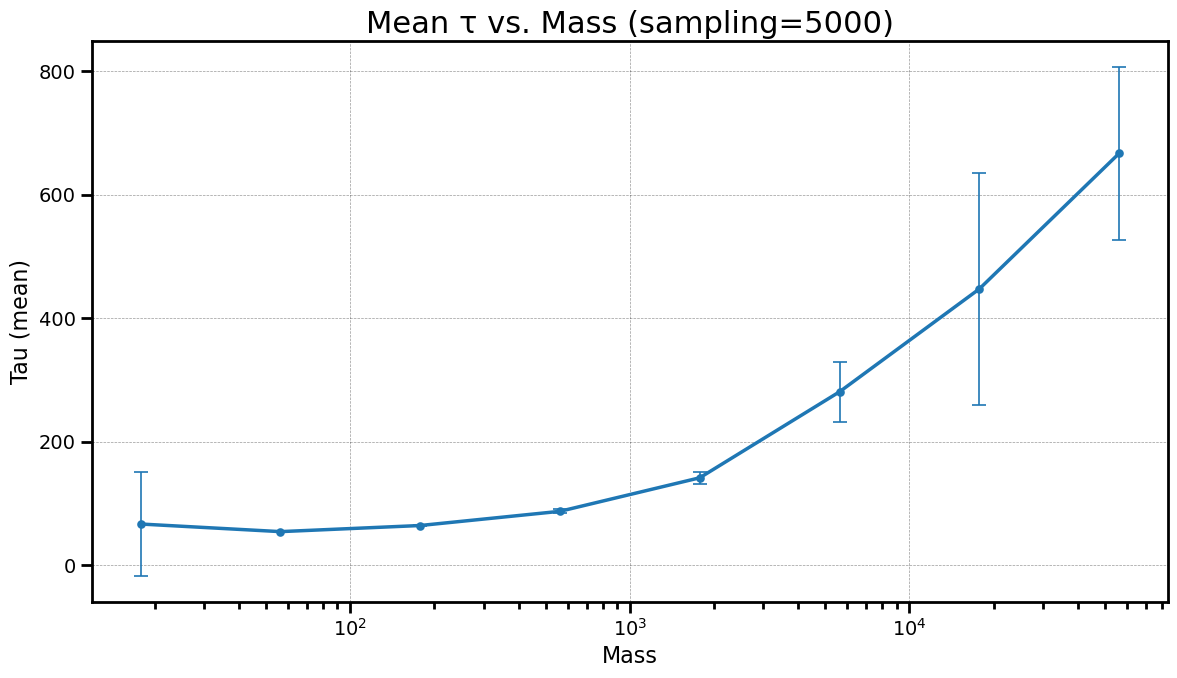

In [139]:
plt.errorbar(x_vals, y_mean, yerr=err,
             fmt='o-',              
             capsize=5,
             elinewidth=1.2,
             markeredgewidth=1.2,
             markersize=5)
plt.xscale('log')
plt.xlabel('Mass')
plt.ylabel('Tau (mean)')
plt.title('Mean τ vs. Mass (sampling=5000)')
plt.grid(True,alpha=0.4)
plt.tight_layout()
plt.show()

In [140]:
import numpy as np

x_vals     = np.array(x_vals)
y_median   = np.array(y_mean)
# err_low    = np.array(err_low)
# err_high   = np.array(err_high)     
err = np.array(err)
mask   = x_vals > 10**3         


M_lin   = x_vals[mask]      
T_lin   = y_median[mask]      
# eL_lin  = err_low[mask]
# eH_lin  = err_high[mask]
err_lin = err[mask]

logM = np.log10(M_lin)
logT = np.log10(T_lin)

# 把不对称误差在 log 空间下近似成对称 σ_y
#   σ_low  = Δ_low / (τ * ln10)
#   σ_high = Δ_high / (τ * ln10)
ln10   = np.log(10)
# sig_low  =  eL_lin / (T_lin * ln10)
# sig_high =  eH_lin / (T_lin * ln10)

sigma_y  = err_lin / (T_lin*ln10)    # 简单平均成“有效 σ”


In [141]:
print(x_vals)

[1.77827941e+01 5.62341325e+01 1.77827941e+02 5.62341325e+02
 1.77827941e+03 5.62341325e+03 1.77827941e+04 5.62341325e+04]


In [142]:
import emcee

def log_like(theta, x, y, yerr):
    a, b, lns_int = theta
    model  = a + b * x
    sigma2 = yerr**2 + np.exp(2*lns_int)     # 显式观测误差 + 内禀散布
    return -0.5 * np.sum((y-model)**2 / sigma2 + np.log(2*np.pi*sigma2))

def log_prior(theta):
    a, b, lns_int = theta
    if -10 < a < 10 and -5 < b < 5 and -10 < lns_int < 2:    # 宽松 uniform
        return 0.0
    return -np.inf

def log_post(theta, x, y, yerr):
    lp = log_prior(theta)
    return lp if not np.isfinite(lp) else lp + log_like(theta, x, y, yerr)

# ——— 初始猜测：普通最小二乘 ————————————
b0, a0 = np.polyfit(logM, logT, deg=1)
lns0   = np.log(np.std(logT - (a0 + b0*logM)))   # 内禀散布初猜
init   = np.array([a0, b0, lns0])

# ——— MCMC 采样 ——————————————
ndim, nwalkers = 3, 32
p0 = init + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim,
                                log_post, args=(logM, logT, sigma_y))
sampler.run_mcmc(p0, 8000, progress=True)


You must install the tqdm library to use progress indicators with emcee


State([[ 0.78088482  0.41304582 -6.54816041]
 [ 0.75051966  0.4442847  -8.19640558]
 [ 0.62245304  0.48369721 -9.40137543]
 [ 0.47868638  0.51801145 -8.76612562]
 [ 0.54813527  0.49595614 -4.79622585]
 [ 0.92757586  0.40317147 -5.48283457]
 [ 0.60075582  0.49072683 -3.80010384]
 [ 1.04953326  0.34906017 -3.38198061]
 [ 0.81020365  0.40878267 -9.88487106]
 [ 0.52344373  0.50176074 -8.96127073]
 [ 0.62215995  0.48089691 -3.72139046]
 [ 0.60434756  0.48088396 -8.50357811]
 [ 0.4713744   0.52404415 -4.78185252]
 [ 0.86302345  0.41894022 -5.13010907]
 [ 0.60226922  0.46020055 -5.58773561]
 [ 0.48270617  0.52353034 -9.64331818]
 [ 0.96181783  0.38564767 -2.76835061]
 [ 0.7283564   0.44762406 -8.91815867]
 [ 0.72810107  0.44157515 -7.0082662 ]
 [ 0.8522967   0.41255418 -5.35805039]
 [ 0.30202632  0.56542816 -9.55517679]
 [ 0.22557066  0.58779461 -7.4633659 ]
 [ 0.5623371   0.5069967  -4.01591269]
 [-0.17338958  0.69391014 -2.01651332]
 [ 0.7471828   0.43163081 -8.90281176]
 [ 0.65649846  0.47

In [143]:
flat = sampler.get_chain(discard=2000, thin=10, flat=True)

a_med, b_med, lns_med = np.percentile(flat, 50, axis=0)
a_err, b_err = np.std(flat[:,0]), np.std(flat[:,1])

print(f"a = {a_med:.4f} ± {a_err:.4f}")
print(f"b = {b_med:.4f} ± {b_err:.4f}")
print(f"σ_int ≈ {np.exp(lns_med):.3f} dex")
print(f'log_tau = a + b*log_mass')



a = 0.6400 ± 0.5305
b = 0.4666 ± 0.1253
σ_int ≈ 0.002 dex
log_tau = a + b*log_mass


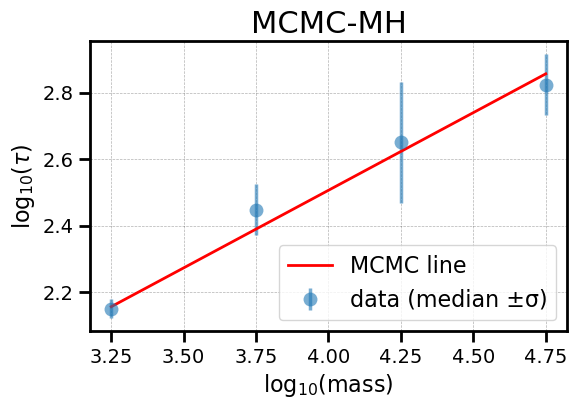

In [144]:

xfit = np.linspace(logM.min(), logM.max(), 200)
yfit = a_med + b_med * xfit

plt.figure(figsize=(6,4))
plt.errorbar(logM, logT, yerr=sigma_y, fmt='o', capsize=3,
             alpha=0.6, label='data (median ±σ)')

plt.plot(xfit, yfit, 'r-', lw=2, label='MCMC line')
plt.plot()
plt.xlabel(r'$\log_{10}(\mathrm{mass})$')
plt.ylabel(r'$\log_{10}(\tau)$')
plt.legend()
plt.tight_layout()
plt.title('MCMC-MH')
plt.show()



In [129]:
#JackKnife
data_jk_o = data_read[['X','Y','Z','Vx','Vy','Vz','Mass']]
data_jk = np.array(data_jk_o)
print(data_jk)

[[ 4.3718810e+01  4.8813640e+01  1.4759496e+02 ...  4.5085000e+02
  -2.6074692e+02  1.8945173e+05]
 [ 4.5442272e+01  5.1850200e+01  1.4641650e+02 ... -7.3588890e+02
   4.0064172e+02  5.3636387e+04]
 [ 4.4490760e+01  4.9091713e+01  1.4787057e+02 ...  1.4954402e+03
  -1.7970822e+03  1.3233013e+03]
 ...
 [ 4.4697636e+01  4.7188305e+01  1.4988548e+02 ...  1.2859307e+03
  -1.0250597e+02  9.4180490e+00]
 [ 4.3667706e+01  7.3888084e+01  1.4798112e+02 ... -2.8787842e+02
  -6.7989390e+02  5.3989470e+00]
 [ 4.5803550e+01  6.9286766e+01  1.4547922e+02 ...  2.4142065e+02
   3.5762564e+02  6.3401090e+00]]


In [130]:
struct_dtype = np.dtype([
    ('Pos', np.float32, 3),
    ('Vel', np.float32, 3),
    ('CentralMvir', np.float32),
])
jk_struct = np.empty(data_jk.shape[0], dtype=struct_dtype)

jk_struct['Pos']         = data_jk[:, 0:3]
jk_struct['Vel']         = data_jk[:, 3:6]
jk_struct['CentralMvir'] = data_jk[:, 6]

In [131]:
import nbodykit as nb
jk_np = jk_struct
jk_struct = nb.source.catalog.ArrayCatalog(jk_np)

In [132]:
def momentum(cat,BoxSize=205):
    LOS = [1,0,0]
    cat['Vx'] = (cat['Vel'] @ LOS) 
    momentum_mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=256, BoxSize=BoxSize, resampler='tsc', position='Pos', value='Vx')
    mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=256, BoxSize=BoxSize, resampler='tsc', position='Pos')
    r01 = FFTPower(momentum_mesh, mode='1d', poles=[1], second=mesh, los=LOS)
    P01 = 2 * r01.poles['k'] * r01.poles['power_1'].imag
    return r01, P01

In [133]:
#jackknife

cat_all = jk_struct 

BoxSize = 205.0         
nside   = (8, 8, 8)     
Nmesh   = 256            
LOS_vec = np.array([1, 0, 0], dtype=np.float32)

In [134]:

import numpy as np
from nbodykit.lab import ArrayCatalog    

#块ID
nx, ny, nz = nside
B          = nx * ny * nz                           
block_len  = BoxSize / np.array(nside, dtype=np.float32)

pos = cat_all['Pos'].compute()                      
idx = np.floor(pos / block_len).astype(int) % np.array(nside)
bid = idx[:, 0] + nx*idx[:, 1] + nx*ny*idx[:, 2]        # (N,)

#放于k空间切割
r_full, P_full = momentum(cat_all, BoxSize=BoxSize)
k_mid = r_full.poles['k']
Nk    = k_mid.size

#Jackknife 
P_blocks = np.empty((B, Nk), dtype=np.float32)

for b in range(B):
    mask = (bid != b)                        
    sub_cat = nb.source.catalog.ArrayCatalog(jk_np[mask]) 
    _, P_b  = momentum(sub_cat, BoxSize=BoxSize)
    P_blocks[b] = P_b


# 4. 均值、协方差、方差
P_mean = P_blocks.mean(axis=0)
diff   = P_blocks - P_mean
cov_jk = (B - 1) / B * diff.T @ diff     # (Nk, Nk)
var_jk = np.diag(cov_jk)                 # 方差
sigma  = np.sqrt(var_jk)                 # 1σ 误差

# 5. 结果示例输出
print("k (前 6 个):", k_mid[:6])
print("P01_JK 均值:", P_mean[:6])
print("σ_JK       :", sigma[:6])


k (前 6 个): [0.02627116 0.05048589 0.08050463 0.10826641 0.13613543 0.16867941]
P01_JK 均值: [ 927348.06 1139661.8  1046052.7   589833.06  430202.5   357449.97]
σ_JK       : [805875.75  384026.16  274414.1   130443.45  115025.336  66855.59 ]


In [135]:
print(cov_jk)

[[ 6.4943574e+11 -2.3153705e+09 -4.1934815e+09 ... -4.1743840e+07
  -2.9519680e+06 -2.5337949e+08]
 [-2.3153787e+09  1.4747609e+11  1.5340999e+10 ... -6.3240504e+07
  -5.9811364e+07 -3.2418656e+07]
 [-4.1934830e+09  1.5340999e+10  7.5303100e+10 ...  1.0645852e+08
  -2.0083688e+07 -2.1338375e+06]
 ...
 [-4.1743840e+07 -6.3240484e+07  1.0645849e+08 ...  3.1722724e+07
   2.3030040e+07  2.2288992e+07]
 [-2.9519360e+06 -5.9811352e+07 -2.0083684e+07 ...  2.3030040e+07
   2.9817990e+07  2.2370392e+07]
 [-2.5337946e+08 -3.2418646e+07 -2.1338455e+06 ...  2.2288992e+07
   2.2370392e+07  2.7511116e+07]]


In [150]:
sub_data_2 = data_read[['X','Y','Z','HaloMass','Nex']]

sub_np_2 = np.array(sub_data_2)
Pos_2  = sub_np_2[:, 0:3]  
mass_2 = sub_np_2[:,3]
tau_2 = sub_np_2[:,4]
idx_2 = np.argsort(mass_2)  
mass_sorted_2 = mass_2[idx_2]  
tau_sorted_2  = tau_2[idx_2] 
exp_edges_2 = np.arange(0.5, 5 + 0.5, 0.5)   
edges_2     = 10 ** exp_edges_2 
bin_idx_2 = np.digitize(mass_2, edges_2) - 1 
df_2 = pd.DataFrame({'Pos' : list(map(tuple, Pos_2)),'mass': mass_2, 'tau': tau_2, 'bin': bin_idx})
df_2 = df_2[df_2['bin'].between(0, len(edges_2)-2)]

In [160]:
import numpy as np
import pandas as pd


BoxSize = 205.0                     
nside   = (8, 8, 8)                  
nx, ny, nz = nside
B        = nx * ny * nz              
block_len = BoxSize / np.array(nside) 


# 取出三维坐标并给每个条目打 block ID
pos_arr = np.array(df_2['Pos'].tolist(), dtype=float)   
idx_xyz = np.floor(pos_arr / block_len).astype(int) % np.array(nside)
block_id = idx_xyz[:,0] + nx*idx_xyz[:,1] + nx*ny*idx_xyz[:,2]
df_2['block_id'] = block_id

bin_ids = np.sort(df_2['bin'].unique())
Nb      = len(bin_ids)

# leave-one 均值矩阵：shape = (B, Nb)
leave1_mean = np.full((B, Nb), np.nan, dtype=float)

for b in range(B):
    mask_block = df_2['block_id'] != b   
    for j, bid in enumerate(bin_ids):
        tau_sub = df_2.loc[mask_block & (df_2['bin'] == bid), 'tau'].values
        if tau_sub.size > 0:
            leave1_mean[b, j] = tau_sub.mean()


theta_bar   = np.nanmean(leave1_mean, axis=0)           
diff        = leave1_mean - theta_bar                    # 广播

# 方差
tau_var_jk  = (B - 1) / B * np.nansum(diff**2, axis=0)  

# 协方差
tau_cov_jk  = (B - 1) / B * np.nan_to_num(diff).T @ np.nan_to_num(diff) 


# print("Jackknife mean τ per mass bin:\n", dict(zip(bin_ids, theta_bar)))
# print("\nJackknife σ (std) per mass bin:\n", dict(zip(bin_ids, np.sqrt(tau_var_jk))))
# print("\nCovariance matrix shape:", tau_cov_jk.shape)


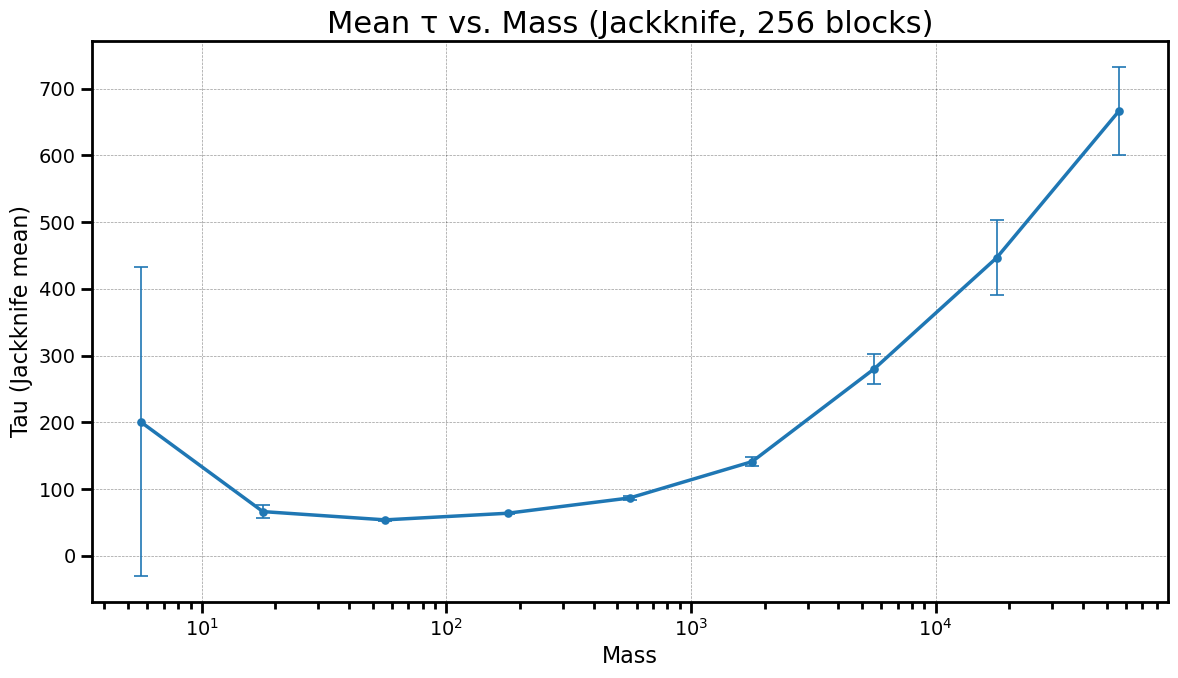

In [161]:

mass_center = np.sqrt(edges_2[:-1] * edges_2[1:])  


center_used = mass_center[bin_ids]       
tau_mean    = theta_bar                  
tau_sigma   = np.sqrt(tau_var_jk)         

# idx_skip = 0                    
# mask     = np.arange(center_used.size) != idx_skip
plt.figure()
plt.errorbar(center_used, tau_mean, yerr=tau_sigma,
             fmt='o-', markersize=5,
             capsize=5, elinewidth=1.2, markeredgewidth=1.2)

plt.xscale('log')
plt.xlabel('Mass')
plt.ylabel('Tau (Jackknife mean)')
plt.title('Mean τ vs. Mass (Jackknife, 256 blocks)')
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


You must install the tqdm library to use progress indicators with emcee



MCMC 结果:
a = 0.6386 ± 0.1017
b = 0.4690 ± 0.0280


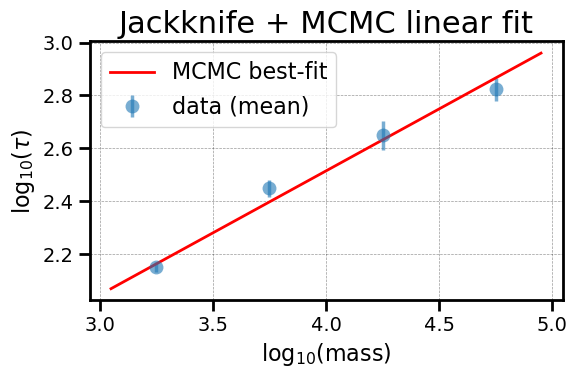

In [164]:
start_idx   = 5                                    
sel         = np.arange(Nb) >= start_idx

M_sel       = mass_center[sel]                     
tau_sel     = theta_bar  [sel]                     
C_sel       = tau_cov_jk[np.ix_(sel, sel)]         


logM_obs    = np.log10(M_sel)
logTau_obs  = np.log10(tau_sel)


ln10        = np.log(10.0)
J_diag      = 1.0 / (tau_sel * ln10)
C_log       = (J_diag[:, None]) * C_sel * (J_diag[None, :])
Cinv_log    = np.linalg.inv(C_log)

def model(theta, x):       
    a, b = theta
    return a + b*x

def lnprior(theta):
    a, b = theta
    return 0.0 if (-5 < a < 5 and -5 < b < 5) else -np.inf

def lnlike(theta):
    resid = logTau_obs - model(theta, logM_obs)
    return -0.5 * resid @ Cinv_log @ resid

def lnprob(theta):
    lp = lnprior(theta)
    return lp + lnlike(theta) if np.isfinite(lp) else -np.inf

# --- MCMC 运行 ---
ndim, nwalkers, nsteps = 2, 32, 5000
rng  = np.random.default_rng(0)
p0   = rng.normal(loc=[0., 1.], scale=[0.5,0.5], size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
sampler.run_mcmc(p0, nsteps, progress=True)

burn   = nsteps // 5
flat   = sampler.get_chain(discard=burn, flat=True)
a_fit, b_fit = flat.mean(axis=0)
a_err, b_err = flat.std(axis=0)

print(f"\nMCMC 结果:")
print(f"a = {a_fit:.4f} ± {a_err:.4f}")
print(f"b = {b_fit:.4f} ± {b_err:.4f}")


sigma_y = np.sqrt(tau_var_jk[sel]) / (tau_sel * ln10)

xfit = np.linspace(logM_obs.min()-0.2, logM_obs.max()+0.2, 300)
yfit = a_fit + b_fit * xfit

plt.figure(figsize=(6,4))
plt.errorbar(logM_obs, logTau_obs, yerr=sigma_y,
             fmt='o', capsize=3, alpha=0.6,
             label='data (mean)')

plt.plot(xfit, yfit, 'r-', lw=2, label='MCMC best-fit')

plt.xlabel(r'$\log_{10}(\mathrm{mass})$')
plt.ylabel(r'$\log_{10}(\tau)$')
plt.title('Jackknife + MCMC linear fit')
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()